In [1]:
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [2]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = 'train_set'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(300)

,File,DiseaseID,Disease Type
0,Pepper__bell___Bacterial_spot/28cb6224-3cd7-43...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/539b8a7d-f257-49...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/32d3951c-8c10-4e...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/8295d0d3-a2b8-4f...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/243bfff2-bd35-44...,0,Pepper__bell___Bacterial_spot
...,...,...,...
295,Pepper__bell___Bacterial_spot/da357d28-8de5-4d...,0,Pepper__bell___Bacterial_spot
296,Pepper__bell___Bacterial_spot/524b0b87-2adb-40...,0,Pepper__bell___Bacterial_spot
297,Pepper__bell___Bacterial_spot/17557939-f9e2-43...,0,Pepper__bell___Bacterial_spot
298,Pepper__bell___Bacterial_spot/bba6a3b8-273f-4c...,0,Pepper__bell___Bacterial_spot


In [4]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato__Tomato_mosaic_virus/c1ff629a-8390-43a4...,13,Tomato__Tomato_mosaic_virus
1,Potato___Late_blight/22d5cf8c-308f-417d-9b05-b...,3,Potato___Late_blight
2,Tomato_Bacterial_spot/3da1608f-81b2-4531-9079-...,5,Tomato_Bacterial_spot
3,Potato___Early_blight/3a314933-9e92-4c90-acc2-...,2,Potato___Early_blight
4,Tomato_Septoria_leaf_spot/4e868db4-c951-461f-a...,9,Tomato_Septoria_leaf_spot


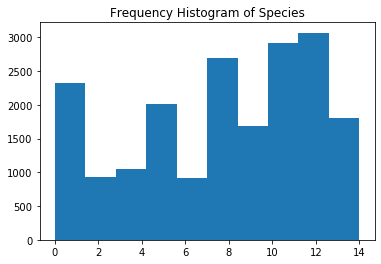

<Figure size 864x864 with 0 Axes>

In [5]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

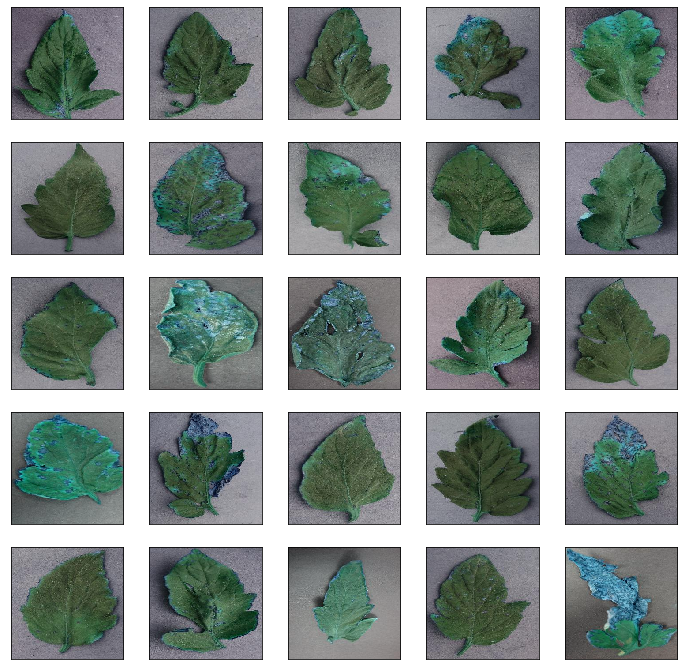

In [6]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [7]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

19385it [00:12, 1495.45it/s]


Train Shape: (19385, 64, 64, 3)


In [9]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [10]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

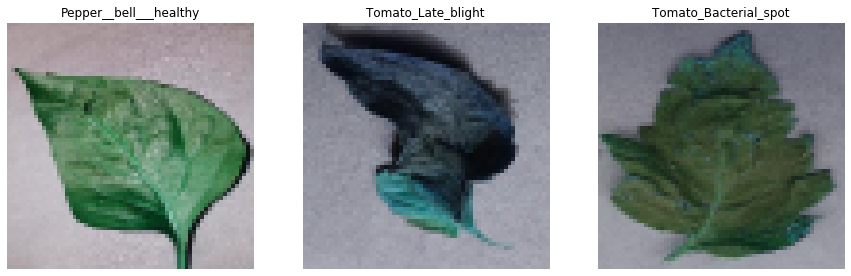

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [12]:
EPOCHS = 5
SIZE = 64
N_ch = 3

In [13]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [14]:
model = build_densenet()  # Model's benefit from reducing the learning rate!
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3) # Reducing learning rate
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)  # Callback to save the Keras model or model weights at some frequency

# Generates batches of image data with data augmentation

datagen = ImageDataGenerator(rotation_range=360,    # Degree range for random rotations
                        width_shift_range=0.2,      # Range for random horizontal shifts
                        height_shift_range=0.2,     # Range for random vertical shifts
                        zoom_range=0.2,             # Range for random zoom
                        horizontal_flip=True,       # Randomly flip inputs horizontally
                        vertical_flip=True)         # Randomly flip inputs vertically

datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

/home/sharingan-coder/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
242/242 - 374s - loss: 2.5815 - accuracy: 0.3146 - val_loss: 1.3326 - val_accuracy: 0.5847

Epoch 00001: val_loss improved from inf to 1.33263, saving model to model.h5
Epoch 2/5
242/242 - 361s - loss: 1.1778 - accuracy: 0.6328 - val_loss: 1.0260 - val_accuracy: 0.6980

Epoch 00002: val_loss improved from 1.33263 to 1.02602, saving model to model.h5
Epoch 3/5
242/242 - 358s - loss: 0.7938 - accuracy: 0.7452 - val_loss: 0.8551 - val_accuracy: 0.7444

Epoch 00003: val_loss improved from 1.02602 to 0.85507, saving model to model.h5
Epoch 4/5
242/242 - 363s - loss: 0.6134 - accuracy: 0.8004 - val_loss: 1.0595 - val_accuracy: 0.6925

Epoch 00004: val_loss did not improve from 0.85507
Epoch 5/5
242/242 - 359s - loss: 0.4905 - accuracy: 0.8403 - val_loss: 0.9339 - val_accuracy: 0.7400

Epoch 00005: val_loss did not improve from 0.85507


In [15]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

122/122 [==============================] - 17s 141ms/step - loss: 0.9339 - accuracy: 0.7400
Final Loss: 0.9339359402656555, Final Accuracy: 0.7400051355361938


Text(0.5, 144.41374999999996, 'Predicted')

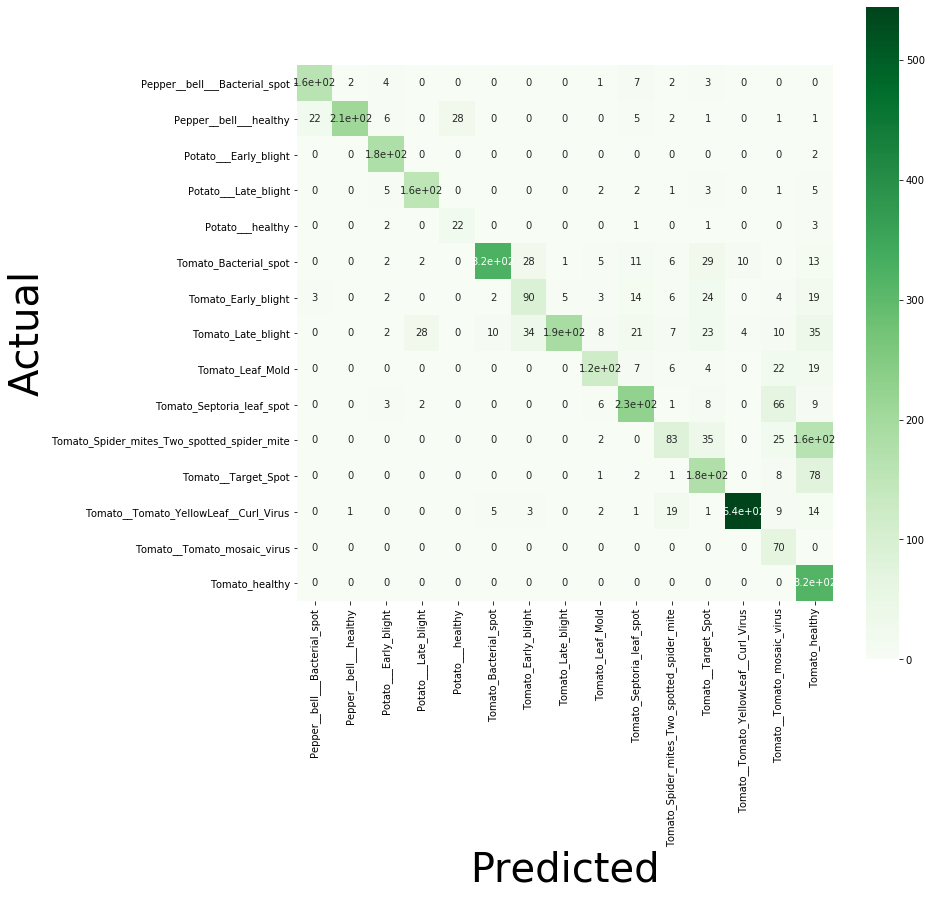

In [16]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

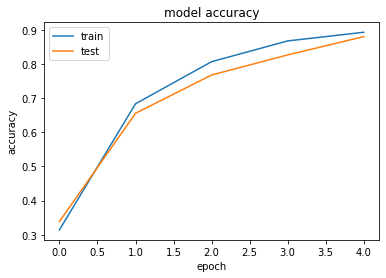

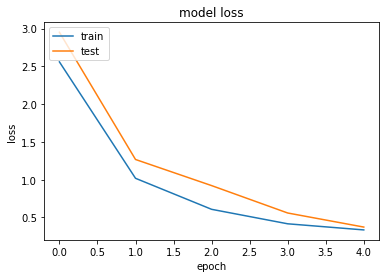

In [17]:
# model accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# model loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[1.6011705e-03 1.4247349e-01 8.5168773e-01 1.4129822e-04 3.0207608e-03
 9.1712775e-07 8.6567534e-06 5.9433230e-05 2.2139426e-05 2.8853235e-04
 7.2177668e-06 2.8076049e-04 5.4786430e-08 4.1178166e-05 3.6662765e-04]


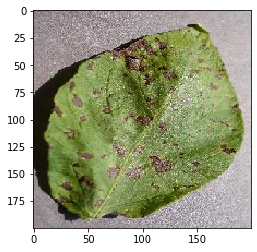

Prediction: Potato___Early_blight


In [19]:
from skimage import io
from keras.preprocessing import image
path='train_set/Potato___Early_blight/3c3a9c2c-3387-4666-9f42-4d14142e9500___RS_Early.B 8499.JPG'
img = image.load_img(path, grayscale=False, target_size=(64, 64), interpolation='nearest')
show_img=image.load_img(path, grayscale=False, target_size=(200, 200), interpolation='nearest')
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])